In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\prash\AppData\Local\Temp\ipykernel_2932\730530028.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
np.random.seed(1)
# Generating training data
x1 = np.random.uniform(7, size=100).round(2)
x2 = np.random.uniform(7, size=100).round(2)
x3 = np.random.uniform(-7, 0, size=100).round(2)
x4 = np.random.uniform(-7, 0, size=100).round(2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y': [0]*50})
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y': [1]*50})
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y': [1]*50})
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y': [0]*50})

train_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])
train_data

,x1,x2,y
0,4.50,5.04,0
1,2.68,3.84,0
2,7.00,1.68,0
3,5.19,4.86,0
4,6.12,1.55,0
...,...,...,...
45,-6.52,-1.09,0
46,-4.35,-4.33,0
47,-6.44,-1.75,0
48,-0.12,-3.42,0


<function matplotlib.pyplot.show(close=None, block=None)>

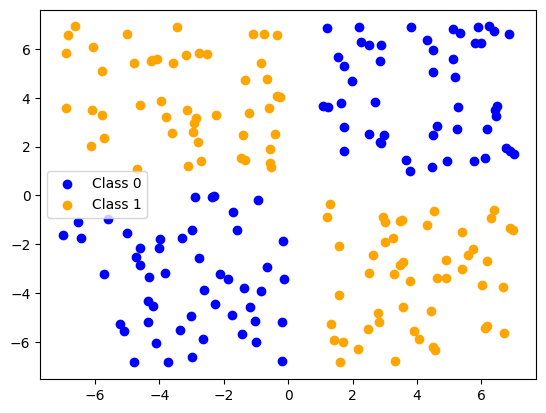

In [3]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(train_data['x1'][train_data['y'] == 0], train_data['x2'][train_data['y'] == 0], color = 'blue', label='Class 0')
ax.scatter(train_data['x1'][train_data['y'] == 1], train_data['x2'][train_data['y'] == 1], color = 'orange', label='Class 1')
ax.legend()
plt.show

In [4]:
np.random.seed(20)
# Generating test data
x1 = np.random.uniform(7, size=100).round(2)
x2 = np.random.uniform(7, size=100).round(2)
x3 = np.random.uniform(-7, 0, size=100).round(2)
x4 = np.random.uniform(-7, 0, size=100).round(2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y1': [0]*50})
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y1': [1]*50})
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y1': [1]*50})
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y1': [0]*50})

test_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])

<function matplotlib.pyplot.show(close=None, block=None)>

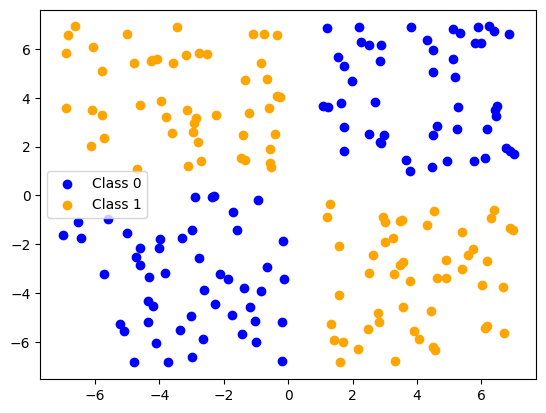

In [5]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(test_data['x1'][test_data['y1'] == 0], test_data['x2'][test_data['y1'] == 0], color = 'blue', label='Class 0')
ax.scatter(test_data['x1'][test_data['y1'] == 1], test_data['x2'][test_data['y1'] == 1], color = 'orange', label='Class 1')
ax.legend()
plt.show

In [6]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [7]:
# Shuffle train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [8]:
# Define features and target variable
X_train = train_data[['x1', 'x2']].values.astype(np.float32)
y_train = train_data['y'].values.reshape(-1, 1).astype(np.float32)
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)

In [9]:
# Create DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

## MLP

In [10]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    

# # Define the three-layer MLP model with ReLU activation
# class ThreeLayerMLP(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2):
#         super(ThreeLayerMLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, 1)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         out = self.sigmoid(out)
#         return out



In [11]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
model

MLP(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [12]:
# baseline accuracy and loss
accuracy, train_loss = 0, 0
for inputs, labels in train_loader:
    outputs = model(inputs)
    predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
    accuracy += torch.sum(predicted_labels == labels)
    loss = criterion(outputs, labels)
    train_loss += loss.item() 

print(f'Baseline accuracy {accuracy / len(train_loader.dataset)}, Baseline loss {train_loss/len(train_loader)}')

Baseline accuracy 0.36500000953674316, Baseline loss 0.8108629584312439


In [13]:
# Training loop
epochs = 5000
train_losses = []
prev_loss = float('inf')  # Initialize previous loss to infinity
tolerance = 1e-5  # Define a tolerance level for convergence
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f} loss {train_loss/len(train_loader):.4f}')
    
    # Check for convergence
    if prev_loss - train_loss < tolerance:
        print(f'Convergence reached at epoch {epoch}. Stopping training.')
        break

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')

Epoch 0 Accuracy 0.3650 loss 0.8109
Epoch 100 Accuracy 1.0000 loss 0.0139
Epoch 200 Accuracy 1.0000 loss 0.0043
Epoch 300 Accuracy 1.0000 loss 0.0021
Epoch 400 Accuracy 1.0000 loss 0.0013
Epoch 500 Accuracy 1.0000 loss 0.0009
Epoch 600 Accuracy 1.0000 loss 0.0006
Epoch 700 Accuracy 1.0000 loss 0.0005
Epoch 800 Accuracy 1.0000 loss 0.0004
Epoch 900 Accuracy 1.0000 loss 0.0003
Epoch 1000 Accuracy 1.0000 loss 0.0002
Epoch 1100 Accuracy 1.0000 loss 0.0002
Epoch 1200 Accuracy 1.0000 loss 0.0002
Epoch 1300 Accuracy 1.0000 loss 0.0001
Epoch 1400 Accuracy 1.0000 loss 0.0001
Epoch 1500 Accuracy 1.0000 loss 0.0001
Epoch 1600 Accuracy 1.0000 loss 0.0001
Epoch 1700 Accuracy 1.0000 loss 0.0001
Epoch 1800 Accuracy 1.0000 loss 0.0001
Epoch 1900 Accuracy 1.0000 loss 0.0001
Epoch 2000 Accuracy 1.0000 loss 0.0001
Epoch 2100 Accuracy 1.0000 loss 0.0001
Epoch 2200 Accuracy 1.0000 loss 0.0000
Epoch 2300 Accuracy 1.0000 loss 0.0000
Epoch 2400 Accuracy 1.0000 loss 0.0000
Epoch 2500 Accuracy 1.0000 loss 0.000

In [14]:
# MLP on test_data
test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
print(f'Test loss: {test_loss/len(test_loader):.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.0000, accuracy: 1.0000


In [15]:
input = torch.tensor([0.48, -0.15])
output = model(input)
print(output)

tensor([0.5086], grad_fn=<SigmoidBackward0>)


In [16]:
# Create meshgrid data for visualization
xx = torch.arange(-7.0, 8.0).clone().detach()
yy = torch.arange(-7.0, 8.0).clone().detach()
xx, yy = torch.meshgrid(xx, yy)

# Flatten meshgrid data
xx1 = xx.reshape(-1, 1)
yy1 = yy.reshape(-1, 1)

# Combine xx1 and yy1 to create input data
data = torch.hstack([xx1, yy1])

# Get predictions from the model
z = model(data)

# Threshold predictions to get binary values
z = torch.where(z > 0.5, 1, 0)

# Reshape z to match the meshgrid dimensions
z = z.reshape(15, 15)


c:\Users\prash\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Decision surface of MLP 

<function matplotlib.pyplot.show(close=None, block=None)>

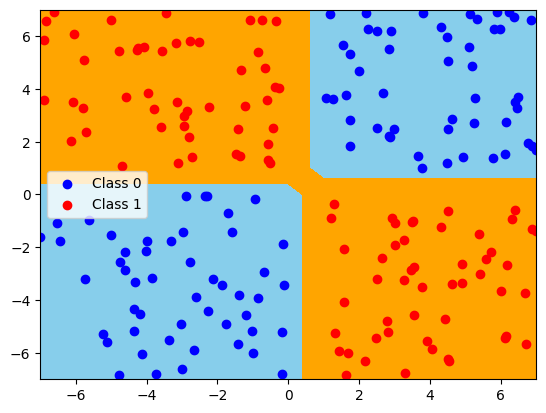

In [17]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue', label='Class 0')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red', label='Class 1')
ax.legend()
plt.show

## MLP with L1 Regularisation

In [18]:
def create_train_val_loader(train_data, i, block_size, batch_size_train=200, batch_size_val=40):
    start = i * block_size
    end = start + block_size

    val_dataset = train_data[start:end].reset_index(drop=True)
    X_val = val_dataset[['x1', 'x2']].values.astype(np.float32)
    y_val = val_dataset['y'].values.reshape(-1, 1).astype(np.float32)
    val_dataset = CustomDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    Xy_train = pd.concat([train_data[:start], train_data[end:]], axis=0).reset_index(drop=True)
    X_train = Xy_train[['x1', 'x2']].values.astype(np.float32)
    y_train = Xy_train['y'].values.reshape(-1, 1).astype(np.float32)
    train_dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

    return train_loader, val_loader

In [19]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [0.0001, 0.001, 0.01, 0.1, 1]:
    for regularization_coefficient in [0.0001, 0.001, 0.01, 0.1, 1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            #  Splitting Train into Train and Validation Dataset
            train_loader, val_loader = create_train_val_loader(train_data, i,block)

            # Initialize MLP
            model = MLP(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        params = params.view(-1)
                        sum += torch.sum(torch.abs(params))  # L1 regularization term

                    loss += regularization_coefficient * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() 
                
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation,for {learning_rate}_{regularization_coefficient} Training loss: {total_train_loss:.4f}')

            # Validation
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:    
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        params = params.view(-1)
                        sum += torch.sum(torch.abs(params))  # L1 regularization term
                    loss += regularization_coefficient * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_loader.dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_loader.dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_acc'] = np.mean(k_cross_val_acc)


Epoch 0 Accuracy 0.5063
Epoch 100 Accuracy 0.5125
Epoch 200 Accuracy 0.5125
Epoch 300 Accuracy 0.5125
Epoch 400 Accuracy 0.5125
Epoch 500 Accuracy 0.5125
Epoch 600 Accuracy 0.5125
Epoch 700 Accuracy 0.5125
Epoch 800 Accuracy 0.5125
Epoch 900 Accuracy 0.5125
In 1 Cross validation,for 0.0001_0.0001 Training loss: 0.9124
Validation loss: 0.7823, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.4938
Epoch 100 Accuracy 0.5125
Epoch 200 Accuracy 0.5437
Epoch 300 Accuracy 0.5688
Epoch 400 Accuracy 0.5750
Epoch 500 Accuracy 0.6062
Epoch 600 Accuracy 0.6125
Epoch 700 Accuracy 0.6375
Epoch 800 Accuracy 0.6562
Epoch 900 Accuracy 0.6562
In 2 Cross validation,for 0.0001_0.0001 Training loss: 0.6902
Validation loss: 0.6589, Validation accuracy: 0.6250
Epoch 0 Accuracy 0.5375
Epoch 100 Accuracy 0.5375
Epoch 200 Accuracy 0.5375
Epoch 300 Accuracy 0.5375
Epoch 400 Accuracy 0.5375
Epoch 500 Accuracy 0.5375
Epoch 600 Accuracy 0.5375
Epoch 700 Accuracy 0.5375
Epoch 800 Accuracy 0.5375
Epoch 900 Accuracy 0.5

In [20]:
t = pd.DataFrame(valid_loss_acc, index = ['val']).T
t['val'] = t['val'].apply(lambda x: round(x, 2))
t

,val
0.0001_0.0001_loss,0.74
0.0001_0.0001_acc,0.54
0.0001_0.001_loss,0.66
0.0001_0.001_acc,0.52
0.0001_0.01_loss,0.76
0.0001_0.01_acc,0.58
0.0001_0.1_loss,1.50
0.0001_0.1_acc,0.53
0.0001_1_loss,9.86
0.0001_1_acc,0.50


In [21]:
best_params = t.idxmin()  # Find the hyperparameters that minimize the validation loss
best_loss = t.min()  # Get the minimum validation loss
best_accuracy = t.loc[best_params, 'val']  # Get the accuracy corresponding to the best parameters

# Extract learning rate and regularization coefficient as floats
learning_rate = float(best_params['val'].split('_')[0])
regularization_coefficient = float(best_params['val'].split('_')[1])
validation_loss = best_loss['val']

print("Best Hyperparameters (Minimize Validation Loss):")
print("Learning Rate:", learning_rate)
print("Regularization coefficient:", regularization_coefficient)
print("Validation Loss:", validation_loss)


Best Hyperparameters (Minimize Validation Loss):
Learning Rate: 0.1
Regularization coefficient: 0.0001
Validation Loss: 0.01


In [22]:
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# regularization_coefficient = 0.001

# training the model
epochs = 5000
train_losses = []
prev_loss = float('inf')  # Initialize previous loss to infinity
tolerance = 1e-5  # Define a tolerance level for convergence
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            params = params.view(-1)
            sum += torch.sum(torch.abs(params))

        loss += regularization_coefficient * sum
        loss.backward()
        optimizer.step()

        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f} loss {train_loss/len(train_loader):.4f}')

    # Check for convergence
    if prev_loss - train_loss < tolerance:
        print(f'Convergence reached at epoch {epoch}. Stopping training.')
        break

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')

        

Epoch 0 Accuracy 0.0000 loss 0.8496


Epoch 100 Accuracy 0.0000 loss 0.2705
Epoch 200 Accuracy 0.0000 loss 0.2704
Epoch 300 Accuracy 0.0000 loss 0.2703
Epoch 400 Accuracy 0.0000 loss 0.2702
Epoch 500 Accuracy 0.0000 loss 0.2698
Epoch 600 Accuracy 0.0000 loss 0.2690
Epoch 700 Accuracy 0.0000 loss 0.2689
Epoch 800 Accuracy 0.0000 loss 0.2693
Epoch 900 Accuracy 0.0000 loss 0.2689
Epoch 1000 Accuracy 0.0000 loss 0.2688
Epoch 1100 Accuracy 0.0000 loss 0.2690
Epoch 1200 Accuracy 0.0000 loss 0.2688
Epoch 1300 Accuracy 0.0000 loss 0.2690
Epoch 1400 Accuracy 0.0000 loss 0.2688
Epoch 1500 Accuracy 0.0000 loss 0.2689
Epoch 1600 Accuracy 0.0000 loss 0.2689
Epoch 1700 Accuracy 0.0000 loss 0.2688
Epoch 1800 Accuracy 0.0000 loss 0.2688
Epoch 1900 Accuracy 0.0000 loss 0.2689
Epoch 2000 Accuracy 0.0000 loss 0.2688
Epoch 2100 Accuracy 0.0000 loss 0.2688
Epoch 2200 Accuracy 0.0000 loss 0.2691
Epoch 2300 Accuracy 0.0000 loss 0.2690
Epoch 2400 Accuracy 0.0000 loss 0.2690
Epoch 2500 Accuracy 0.0000 loss 0.2689
Epoch 2600 Accuracy 0.0000 loss 0.

In [27]:
# X_test = test_data[['x1', 'x2']].values.astype(np.float32)
# y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
# test_dataset = CustomDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.0004, accuracy: 1.0000


In [28]:
# Generating a grid of points for evaluation
x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
x_values, y_values = torch.meshgrid(x_values, y_values)
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)
grid_data = torch.hstack([x_values, y_values])

# Evaluating the model on the grid
model_outputs = model(grid_data)

# Thresholding the model outputs
thresholded_outputs = torch.where(model_outputs > 0.5, 1, 0)

# Reshaping the thresholded outputs into a 2D grid
z = thresholded_outputs.reshape(15, 15)

C:\Users\prash\AppData\Local\Temp\ipykernel_2932\2695446099.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
C:\Users\prash\AppData\Local\Temp\ipykernel_2932\2695446099.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)


#### Decision surface of MLP with L1 Regularisation

<function matplotlib.pyplot.show(close=None, block=None)>

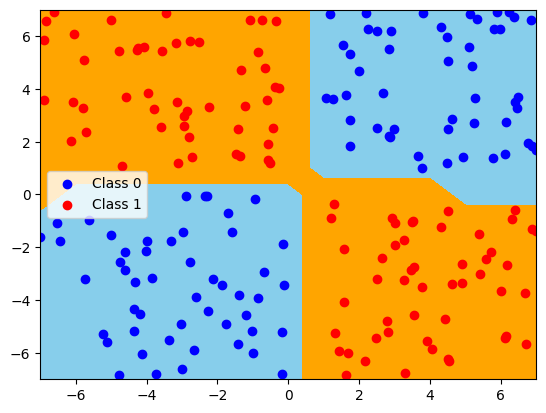

In [29]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue',label='Class 0')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red', label='Class 1')
ax.legend()
plt.show

## MLP with L2 Regularisation

In [30]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [0.0001, 0.001, 0.01, 0.1, 1]:
    for regularization_coefficient in [0.0001, 0.001, 0.01, 0.1, 1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            #  Splitting Train into Train and Validation Dataset
            train_loader, val_loader = create_train_val_loader(train_data, i, block)

            # Initialize MLP
            model = MLP(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        sum += torch.sum(torch.square(params))  # L2 regularization term

                    loss += regularization_coefficient * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() 
                
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation,for {learning_rate}_{regularization_coefficient} Training loss: {total_train_loss:.4f}')

            # Validation
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:    
                    outputs = model(inputs)
                    predicted_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(predicted_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        sum += torch.sum(torch.square(params))  # L2 regularization term
                    loss += regularization_coefficient * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_loader.dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_loader.dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{regularization_coefficient}_acc'] = np.mean(k_cross_val_acc)


Epoch 0 Accuracy 0.5312
Epoch 100 Accuracy 0.5375
Epoch 200 Accuracy 0.5500
Epoch 300 Accuracy 0.5625
Epoch 400 Accuracy 0.5688
Epoch 500 Accuracy 0.5750
Epoch 600 Accuracy 0.5750
Epoch 700 Accuracy 0.5813
Epoch 800 Accuracy 0.5813
Epoch 900 Accuracy 0.6000
In 1 Cross validation,for 0.0001_0.0001 Training loss: 0.6278
Validation loss: 0.6009, Validation accuracy: 0.6000
Epoch 0 Accuracy 0.4938
Epoch 100 Accuracy 0.4938
Epoch 200 Accuracy 0.4875
Epoch 300 Accuracy 0.4750
Epoch 400 Accuracy 0.4688
Epoch 500 Accuracy 0.4625
Epoch 600 Accuracy 0.4625
Epoch 700 Accuracy 0.4563
Epoch 800 Accuracy 0.4563
Epoch 900 Accuracy 0.4563
In 2 Cross validation,for 0.0001_0.0001 Training loss: 0.9995
Validation loss: 0.7711, Validation accuracy: 0.5500
Epoch 0 Accuracy 0.5312
Epoch 100 Accuracy 0.5250
Epoch 200 Accuracy 0.5437
Epoch 300 Accuracy 0.5625
Epoch 400 Accuracy 0.5750
Epoch 500 Accuracy 0.5813
Epoch 600 Accuracy 0.5750
Epoch 700 Accuracy 0.5750
Epoch 800 Accuracy 0.5750
Epoch 900 Accuracy 0.5

In [31]:
t = pd.DataFrame(valid_loss_acc, index = ['val']).T
t['val'] = t['val'].apply(lambda x: round(x, 2))
t

,val
0.0001_0.0001_loss,0.64
0.0001_0.0001_acc,0.67
0.0001_0.001_loss,0.68
0.0001_0.001_acc,0.49
0.0001_0.01_loss,0.70
0.0001_0.01_acc,0.62
0.0001_0.1_loss,1.09
0.0001_0.1_acc,0.52
0.0001_1_loss,3.56
0.0001_1_acc,0.50


In [32]:
best_params = t.idxmin()  # Find the hyperparameters that minimize the validation loss
best_loss = t.min()  # Get the minimum validation loss
best_accuracy = t.loc[best_params, 'val']  # Get the accuracy corresponding to the best parameters

# Extract learning rate and regularization coefficient as floats
learning_rate = float(best_params['val'].split('_')[0])
regularization_coefficient = float(best_params['val'].split('_')[1])
validation_loss = best_loss['val']

print("Best Hyperparameters (Minimize Validation Loss):")
print("Learning Rate:", learning_rate)
print("Regularization coefficient:", regularization_coefficient)
print("Validation Loss:", validation_loss)


Best Hyperparameters (Minimize Validation Loss):
Learning Rate: 0.01
Regularization coefficient: 0.0001
Validation Loss: 0.02


In [34]:
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# regularization_coefficient = 0.001

# training the model
epochs =3000
train_losses = []
prev_loss = float('inf')  # Initialize previous loss to infinity
tolerance = 1e-5  # Define a tolerance level for convergence
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            sum += torch.sum(torch.square(params))

        loss += regularization_coefficient * sum
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f} loss {train_loss/len(train_loader):.4f}')

    # Check for convergence
    if prev_loss - train_loss < tolerance:
        print(f'Convergence reached at epoch {epoch}. Stopping training.')
        break
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')
        

Epoch 0 Accuracy 0.0000 loss 0.9987
Epoch 100 Accuracy 0.0000 loss 0.3228
Epoch 200 Accuracy 0.0000 loss 0.1492
Epoch 300 Accuracy 0.0000 loss 0.0851
Epoch 400 Accuracy 0.0000 loss 0.0562
Epoch 500 Accuracy 0.0000 loss 0.0406
Epoch 600 Accuracy 0.0000 loss 0.0315
Epoch 700 Accuracy 0.0000 loss 0.0259
Epoch 800 Accuracy 0.0000 loss 0.0222
Epoch 900 Accuracy 0.0000 loss 0.0196
Epoch 1000 Accuracy 0.0000 loss 0.0178
Epoch 1100 Accuracy 0.0000 loss 0.0164
Epoch 1200 Accuracy 0.0000 loss 0.0154
Epoch 1300 Accuracy 0.0000 loss 0.0146
Epoch 1400 Accuracy 0.0000 loss 0.0140
Epoch 1500 Accuracy 0.0000 loss 0.0135
Epoch 1600 Accuracy 0.0000 loss 0.0132
Epoch 1700 Accuracy 0.0000 loss 0.0128
Epoch 1800 Accuracy 0.0000 loss 0.0126
Epoch 1900 Accuracy 0.0000 loss 0.0124
Epoch 2000 Accuracy 0.0000 loss 0.0122
Epoch 2100 Accuracy 0.0000 loss 0.0120
Epoch 2200 Accuracy 0.0000 loss 0.0119
Epoch 2300 Accuracy 0.0000 loss 0.0118
Epoch 2400 Accuracy 0.0000 loss 0.0117
Epoch 2500 Accuracy 0.0000 loss 0.011

In [36]:
# X_test = test_data[['x1', 'x2']].values.astype(np.float32)
# y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
# test_dataset = CustomDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(predicted_labels == labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.0064, accuracy: 0.9950


In [37]:
# Generating a grid of points for evaluation
x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
x_values, y_values = torch.meshgrid(x_values, y_values)
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)
grid_data = torch.hstack([x_values, y_values])

# Evaluating the model on the grid
model_outputs = model(grid_data)

# Thresholding the model outputs
thresholded_outputs = torch.where(model_outputs > 0.5, 1, 0)

# Reshaping the thresholded outputs into a 2D grid
z = thresholded_outputs.reshape(15, 15)

C:\Users\prash\AppData\Local\Temp\ipykernel_2932\2695446099.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)
C:\Users\prash\AppData\Local\Temp\ipykernel_2932\2695446099.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_values = torch.tensor(torch.arange(-7.0, 8.0), requires_grad=False)


#### Decision surface of MLP with L2 Regularisation

<function matplotlib.pyplot.show(close=None, block=None)>

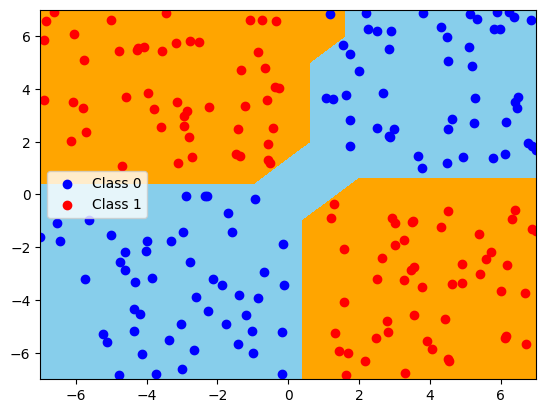

In [38]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue', label='Class 0')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red', label='Class 1')
ax.legend()
plt.show

## Logistic Regression Model

In [39]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [ ]:
# # Shuffle train and test data
# train_data = train_data.sample(frac=1).reset_index(drop=True)
# test_data = test_data.sample(frac=1).reset_index(drop=True)

### With x1^2

In [40]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']**2], axis = 1)
X_train.columns = ['x1','x2','x1^2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)
# y_train

In [41]:
reg = LogisticRegression(3)
optimizer = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    optimizer.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    # print(logits)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    optimizer.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1


pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Training accuracy using Logistic Regression with sqaure of x1 {acc}')

0 2.0745656490325928
10 1.2700557708740234
20 0.8286505341529846
30 0.7638652324676514
40 0.7075726389884949
50 0.7023765444755554
60 0.6993091702461243
70 0.697101891040802
80 0.6957367062568665
90 0.6953976154327393
100 0.6948625445365906
110 0.6945027709007263
120 0.6942097544670105
130 0.6939508318901062
140 0.6937386393547058
150 0.693562924861908
160 0.6934183239936829
170 0.6933011412620544
Training accuracy using Logistic Regression with sqaure of x1 0.44999998807907104


In [42]:
X_test = pd.concat([test_data['x1'], test_data['x2'], test_data['x1']**2], axis = 1)
X_test.columns = ['x1','x2','x1^2']
X_test = torch.tensor(X_test.values, dtype= torch.float32)
y_test = test_data['y1']
y_test = torch.tensor(y_test.values, dtype= torch.float32)


pred = F.sigmoid(reg(X_test))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_test = y_test.reshape(-1, 1)
correct_pred = torch.sum(pred == y_test)
acc = correct_pred / len(y_test)
print(f'Testing accuracy using Logistic Regression with sqaure of x1 {acc}')

Testing accuracy using Logistic Regression with sqaure of x1 0.44999998807907104


In [43]:
xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
xx3 = xx1*xx1
# print(xx3)
data = torch.hstack([xx1, xx2, xx3 ])
z = reg(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(15,15)

C:\Users\prash\AppData\Local\Temp\ipykernel_2932\4244722955.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_2932\4244722955.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)


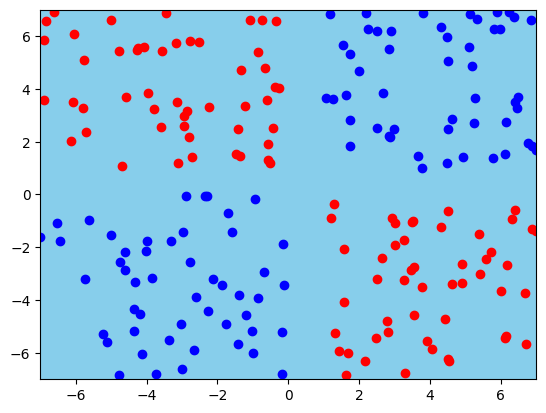

In [44]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

### With x1x2

In [45]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']*train_data['x2']], axis = 1)
X_train.columns = ['x1','x2','x1x2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)

In [46]:
reg = LogisticRegression(3)
opt = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Training accuracy using Logistic Regression with x1x2 {acc}')

0 0.08650961518287659
10 0.061269283294677734
20 0.04811008274555206
30 0.04018315672874451
40 0.03494692221283913
50 0.03112689033150673
60 0.02818770334124565
70 0.025840630754828453
80 0.023904841393232346
90 0.02226804941892624
100 0.020857524126768112
110 0.01962367258965969
120 0.018531516194343567
130 0.017555521801114082
140 0.016676373779773712
150 0.01587914675474167
160 0.01515199989080429
170 0.014485428109765053
180 0.013871679082512856
190 0.013304351828992367
200 0.012778098694980145
210 0.012288416735827923
220 0.011831476353108883
230 0.011404006741940975
240 0.01100316271185875
250 0.010626486502587795
260 0.01027183048427105
270 0.009937302209436893
280 0.009621228091418743
290 0.009322114288806915
300 0.0090386513620615
310 0.008769650012254715
320 0.008514046669006348
330 0.008270869962871075
340 0.00803926307708025
350 0.007818439975380898
360 0.007607674226164818
370 0.007406317163258791
380 0.007213767617940903
390 0.007029479369521141
400 0.006852949038147926
4

In [47]:
X_test = pd.concat([test_data['x1'], test_data['x2'], test_data['x1']*test_data['x2']], axis = 1)
X_test.columns = ['x1','x2','x1x2']
X_test = torch.tensor(X_test.values, dtype= torch.float32)
y_test = test_data['y1']
y_test = torch.tensor(y_test.values, dtype= torch.float32)

pred = F.sigmoid(reg(X_test))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_test = y_test.reshape(-1, 1)
correct_pred = torch.sum(pred == y_test)
acc = correct_pred / len(y_test)
print(f'Testing accuracy using Logistic Regression {acc}')

Testing accuracy using Logistic Regression 1.0


In [48]:
xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
xx3 = xx1 * xx2
data = torch.hstack([xx1, xx2, xx3 ])
z = reg(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(15,15)

C:\Users\prash\AppData\Local\Temp\ipykernel_2932\2389335295.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_2932\2389335295.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-7.0,8.0), requires_grad = False)


#### Decision surface of Logistic regression

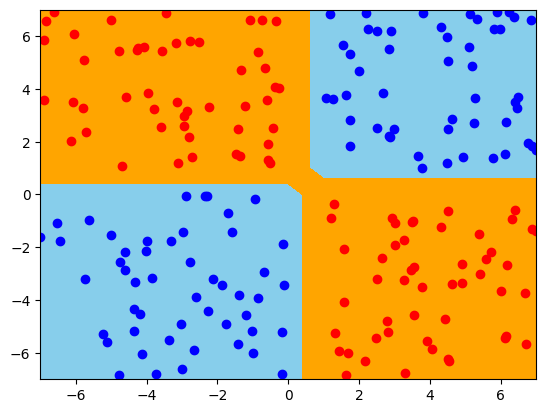

In [49]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

##### In conclusion, after examining the plots generated from various scenarios using the XOR dataset, we observe that all models, including MLP, MLP with L1 regularization, MLP with L2 regularization, and logistic regression, perform well and yield comparable results. They effectively capture the shape of the XOR function, indicating satisfactory performance.

##### When we mention "good results," we imply that the models accurately represent the XOR function's shape. However, it's important to recognize that datasets may contain outliers, which can affect model performance. In such cases, L1 regularization proves to be more robust in handling outliers compared to L2 regularization, as L1 tends to disregard them.

##### Furthermore, it's worth noting that relying solely on MLP models may lead to overfitting and poor generalization, especially with certain datasets. Therefore, incorporating L1 and L2 regularization techniques becomes essential to address these issues and enhance model robustness. Additionally, logistic regression demonstrates commendable performance, particularly when utilizing additional features.

##### For instance, when examining plots generated from different feature combinations such as x1 x2 or x1 x2 and x1**2, the models exhibit poor performance. However, incorporating interaction terms like x1x2 significantly improves the model's ability to capture the XOR shape.

##### In summary, while all models exhibit promising performance in capturing the XOR function's shape, it's crucial to acknowledge the presence of outliers and the need for regularization techniques to enhance model generalization and robustness.